In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Define Functions

In [2]:
def calculate_monthly_performance_metrics(monthly_log_returns_df, risk_free_rate=0.01):
    """
    Calculates key performance metrics from a DataFrame of monthly LOG returns.
    """
    # Ensure input is a pandas Series
    log_returns = monthly_log_returns_df.squeeze()

    # 1. Calculate Total Return (for the entire period)
    # For Log Returns: Total Return = exp(sum of log returns) - 1
    total_return = np.exp(log_returns.sum()) - 1

    # 2. Annualized Return
    num_months = len(log_returns)
    # Step: Convert total return to an annualized compound growth rate
    annualized_return = (1 + total_return) ** (12 / num_months) - 1

    # 3. Annualized Risk (Volatility)
    # Volatility of log returns is a standard proxy for volatility of simple returns
    annualized_risk = log_returns.std() * np.sqrt(12)

    # 4. Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_risk

    # 5. Sortino Ratio
    # We still use the threshold of 0 for downside returns
    downside_returns = log_returns[log_returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(12)

    if downside_deviation == 0 or np.isnan(downside_deviation):
        sortino_ratio = np.inf
    else:
        sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation

    # 6. Monthly Value at Risk (VaR) at 95% Confidence
    # We calculate VaR in simple return terms to be intuitive
    # Simple Return = exp(log_return) - 1
    simple_returns = np.exp(log_returns) - 1
    monthly_var_95 = np.percentile(simple_returns, 5)

    # 7. Monthly Expected Shortfall (CVaR) at 95% Confidence
    monthly_cvar_95 = simple_returns[simple_returns <= monthly_var_95].mean()

    # 8. Maximum Drawdown
    # For Log Returns: Cumulative Wealth = exp(cumsum of log returns)
    cumulative_wealth = np.exp(log_returns.cumsum())
    running_max = cumulative_wealth.cummax()
    drawdown = (cumulative_wealth - running_max) / running_max
    max_drawdown = drawdown.min()

    # Store metrics in a dictionary
    metrics = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Risk': annualized_risk,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Monthly VaR (95%)': monthly_var_95,
        'Monthly CVaR (95%)': monthly_cvar_95,
        'Max Drawdown (%)': max_drawdown
    }

    return pd.Series(metrics, name='Metrics')

# Import Data

In [9]:
# 1. Load the data using the raw URL
url = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_price.csv'
df = pd.read_csv(url)

# 2. Rename dataframe as SET and remove the first two metadata rows
SET = df.iloc[2:].copy()

# 3. Rename columns
SET.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# 4. Set datetime index
SET['Date'] = pd.to_datetime(SET['Date'])
SET.set_index('Date', inplace=True)

# Ensure data is numeric
SET = SET.apply(pd.to_numeric)

# 5. Filter data from December 2015 to the end
SET = SET.loc['2015-12-01':]

In [7]:
SET.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2015-12-01 to 2025-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   121 non-null    float64
 1   High    121 non-null    float64
 2   Low     121 non-null    float64
 3   Open    121 non-null    float64
 4   Volume  121 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 5.7 KB


In [10]:
SET.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-12-01,1288.020020,1294.839966,1285.290039,1285.520020,6316200
2016-01-01,1300.979980,1301.010010,1287.229980,1291.969971,9973500
2016-02-01,1332.369995,1343.939941,1331.569946,1342.430054,7949000
2016-03-01,1407.699951,1412.920044,1402.010010,1406.849976,8050300
2016-04-01,1404.609985,1404.609985,1394.250000,1399.150024,11785200


In [11]:
SET.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-08-01,1236.609985,1255.839966,1236.609985,1248.319946,4142500
2025-09-01,1274.170044,1290.540039,1270.420044,1286.400024,3608500
2025-10-01,1309.500000,1318.329956,1304.109985,1308.030029,2654000
2025-11-01,1256.689941,1264.109985,1251.140015,1256.739990,2541600
2025-12-01,1259.670044,1260.469971,1251.349976,1251.349976,2528600


In [15]:
SET.index

DatetimeIndex(['2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01',
               ...
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01',
               '2025-11-01', '2025-12-01'],
              dtype='datetime64[ns]', name='Date', length=121, freq=None)

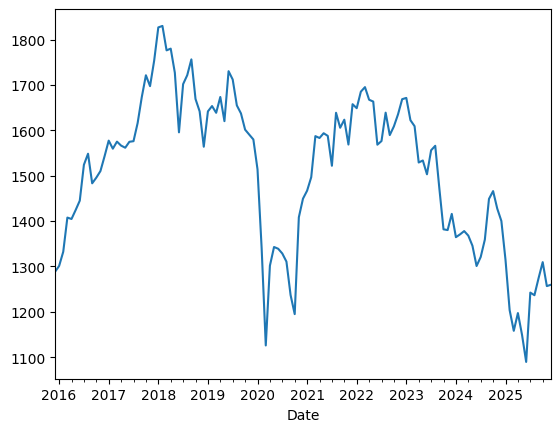

In [8]:
SET.Close.plot(kind= 'line');

# Calculate Log Returns

In [13]:
# Calculate retuns
SET_ret = np.log(SET['Close'] / SET['Close'].shift(1))

# Train-test split
SET_ret_train = SET_ret.loc['2016-01-01':'2022-12-01']
SET_ret_test = SET_ret.loc['2023-01-01':]

In [18]:
SET_ret_train.head(), SET_ret_train.tail()

(Date
 2016-01-01    0.010012
 2016-02-01    0.023841
 2016-03-01    0.054998
 2016-04-01   -0.002197
 2016-05-01    0.013907
 Name: Close, dtype: float64,
 Date
 2022-08-01    0.038893
 2022-09-01   -0.030618
 2022-10-01    0.012038
 2022-11-01    0.016399
 2022-12-01    0.020158
 Name: Close, dtype: float64)

In [19]:
SET_ret_test.head(), SET_ret_test.tail()

(Date
 2023-01-01    0.001677
 2023-02-01   -0.029822
 2023-03-01   -0.008157
 2023-04-01   -0.051026
 2023-05-01    0.002886
 Name: Close, dtype: float64,
 Date
 2025-08-01   -0.004631
 2025-09-01    0.029921
 2025-10-01    0.027350
 2025-11-01   -0.041164
 2025-12-01    0.002369
 Name: Close, dtype: float64)

# Calculate Buy-and-Hold Strategy (Benchmark)

In [22]:
# Define the cost (Fee + VAT)
trading_fee_rate = 0.0015
vat_rate = 0.07
total_cost_rate = trading_fee_rate * (1 + vat_rate)

# negative impact of the fee on the wealth factor.
log_cost = np.log(1 - total_cost_rate)

In [23]:
# We subtract the cost from the return of the first month we buy
SET_ret_train.iloc[0] = SET_ret_train.iloc[0] + total_cost_rate
SET_ret_test.iloc[0] = SET_ret_test.iloc[0] + total_cost_rate

# We subtract the cost from the final return when we sell
SET_ret_train.iloc[-1] = SET_ret_train.iloc[-1] + total_cost_rate
SET_ret_test.iloc[-1] = SET_ret_test.iloc[-1] + total_cost_rate

In [24]:
# Calculate training period performance
calculate_monthly_performance_metrics(SET_ret_train, 0)

,Metrics
Total Return,0.299689
Annualized Return,0.038156
Annualized Risk,0.156308
Sharpe Ratio,0.244110
Sortino Ratio,0.317782
Monthly VaR (95%),-0.055202
Monthly CVaR (95%),-0.092842
Max Drawdown (%),-0.384820


In [25]:
# Calculate testing period performance
calculate_monthly_performance_metrics(SET_ret_test, 0)

,Metrics
Total Return,-0.242674
Annualized Return,-0.088491
Annualized Risk,0.143708
Sharpe Ratio,-0.615768
Sortino Ratio,-1.098733
Monthly VaR (95%),-0.060973
Monthly CVaR (95%),-0.072744
Max Drawdown (%),-0.348139
